# **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# **2. Data Understanding**

### 2.1 Data Loading

In [2]:
# Load and clean data
file_path = "cleaned_animal_disease_prediction.csv"
df = pd.read_csv(file_path).drop(columns=['Animal_Type'])
df.head()

,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Duration,Appetite_Loss,...,Diarrhea,Coughing,Labored_Breathing,Lameness,Skin_Lesions,Nasal_Discharge,Eye_Discharge,Body_Temperature,Heart_Rate,Disease_Prediction
0,Labrador,4,Male,25.0,Fever,Lethargy,Appetite Loss,Vomiting,3 days,Yes,...,No,No,No,No,No,No,No,39.5°C,120,Parvovirus
1,Siamese,2,Female,4.5,Coughing,Sneezing,Eye Discharge,Nasal Discharge,1 week,No,...,No,Yes,No,No,No,Yes,Yes,38.9°C,150,Upper Respiratory Infection
2,Holstein,3,Female,600.0,Fever,Nasal Discharge,Labored Breathing,Coughing,5 days,Yes,...,No,Yes,Yes,No,No,Yes,No,40.1°C,90,Foot and Mouth Disease
3,Beagle,1,Male,10.0,Diarrhea,Vomiting,Lethargy,Appetite Loss,2 days,Yes,...,Yes,No,No,No,No,No,No,39.2°C,130,Gastroenteritis
4,Persian,5,Male,3.8,Lethargy,Appetite Loss,Skin Lesions,No,2 weeks,Yes,...,No,No,No,No,Yes,No,No,38.7°C,160,Fungal Infection


# **3. Exploratory Data Analysis (EDA)**

In [3]:
#Meninjau jumlah baris dan kolom dataset
jumlah_baris, jumlah_kolom = df.shape

print(f"Jumlah baris (rows): {jumlah_baris}")
print(f"Jumlah kolom (columns): {jumlah_kolom}")

Jumlah baris (rows): 431
Jumlah kolom (columns): 21


In [4]:
#Menampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Breed               431 non-null    object 
 1   Age                 431 non-null    int64  
 2   Gender              431 non-null    object 
 3   Weight              431 non-null    float64
 4   Symptom_1           431 non-null    object 
 5   Symptom_2           431 non-null    object 
 6   Symptom_3           431 non-null    object 
 7   Symptom_4           431 non-null    object 
 8   Duration            431 non-null    object 
 9   Appetite_Loss       431 non-null    object 
 10  Vomiting            431 non-null    object 
 11  Diarrhea            431 non-null    object 
 12  Coughing            431 non-null    object 
 13  Labored_Breathing   431 non-null    object 
 14  Lameness            431 non-null    object 
 15  Skin_Lesions        431 non-null    object 
 16  Nasal_Di

In [5]:
#Memeriksa Missing Values pada dataset
df.isnull().sum()

,0
Breed,0
Age,0
Gender,0
Weight,0
Symptom_1,0
Symptom_2,0
Symptom_3,0
Symptom_4,0
Duration,0
Appetite_Loss,0


In [6]:
## ringkasan statistik dataset
df.describe()

,Age,Weight,Heart_Rate
count,431.000000,431.000000,431.000000
mean,5.044084,214.441067,105.582367
std,2.553685,259.594305,27.892936
min,1.000000,1.000000,70.000000
25%,3.000000,8.000000,80.000000
50%,5.000000,80.000000,92.000000
75%,6.000000,500.000000,130.000000
max,16.000000,850.000000,165.000000


In [7]:
#menampilkan jumlah label kolom Disease
df['Disease_Prediction'].value_counts()

,count
Disease_Prediction,
Bovine Tuberculosis,15
Bovine Respiratory Disease,14
Equine Influenza,13
Canine Parvovirus,12
Caprine Arthritis Encephalitis,12
...,...
Goat Pox,1
Porcine Epidemic Diarrhea Virus,1
Canine Infectious Hepatitis,1


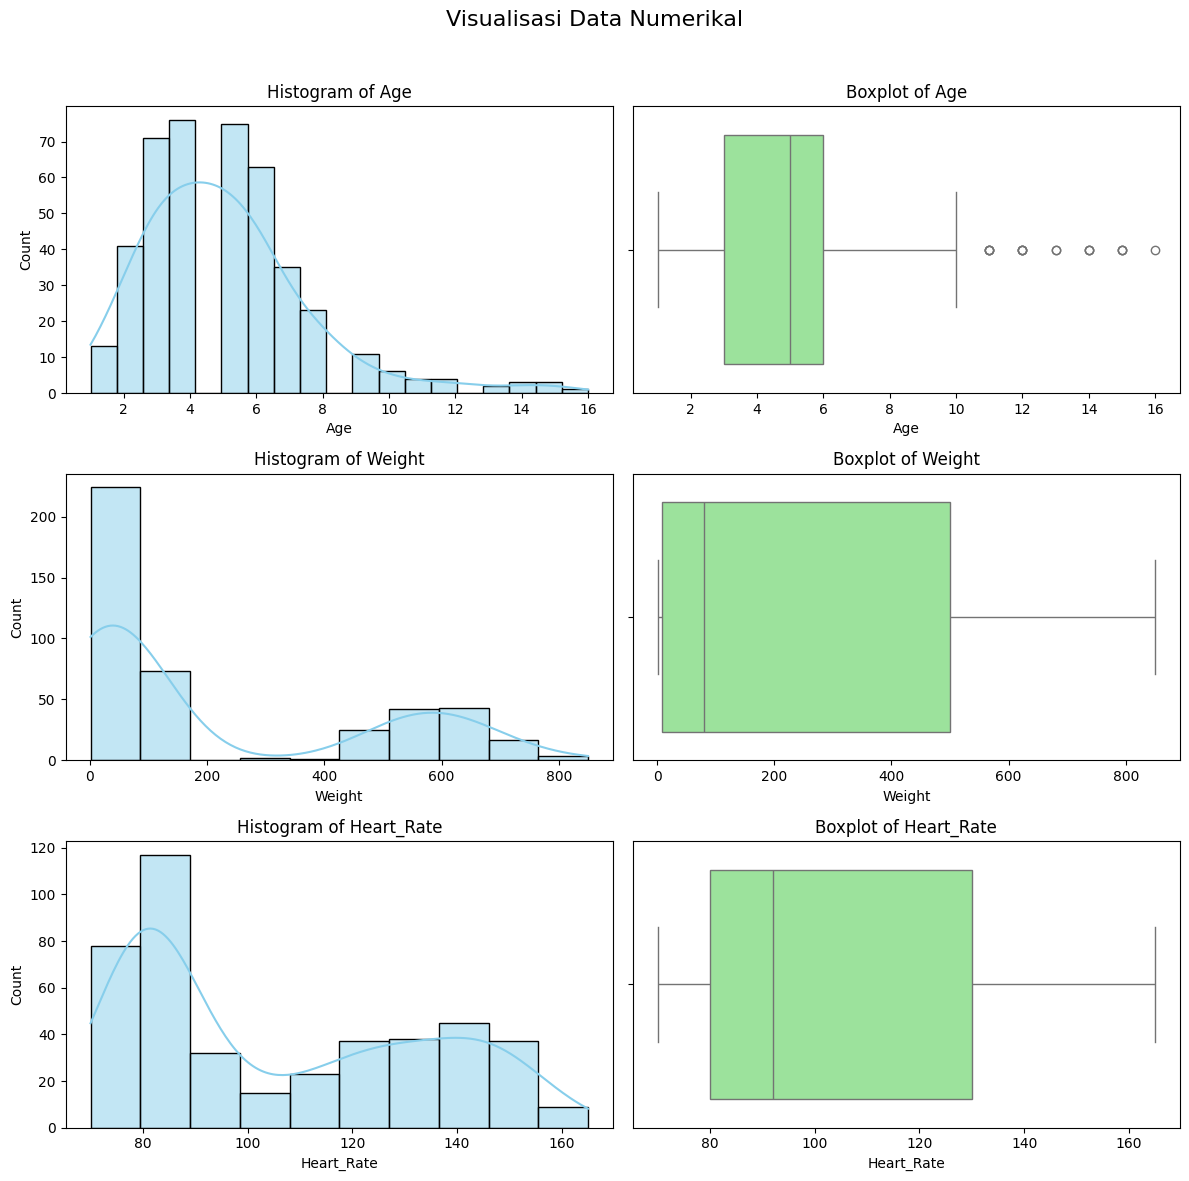

In [8]:
#Visualisasi data numerik menggunakan histogram dan boxplot
numerical_cols = ['Age', 'Weight', 'Heart_Rate']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.suptitle("Visualisasi Data Numerikal", fontsize=16)

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i][0], color='skyblue')
    axes[i][0].set_title(f'Histogram of {col}')
    sns.boxplot(x=df[col], ax=axes[i][1], color='lightgreen')
    axes[i][1].set_title(f'Boxplot of {col}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

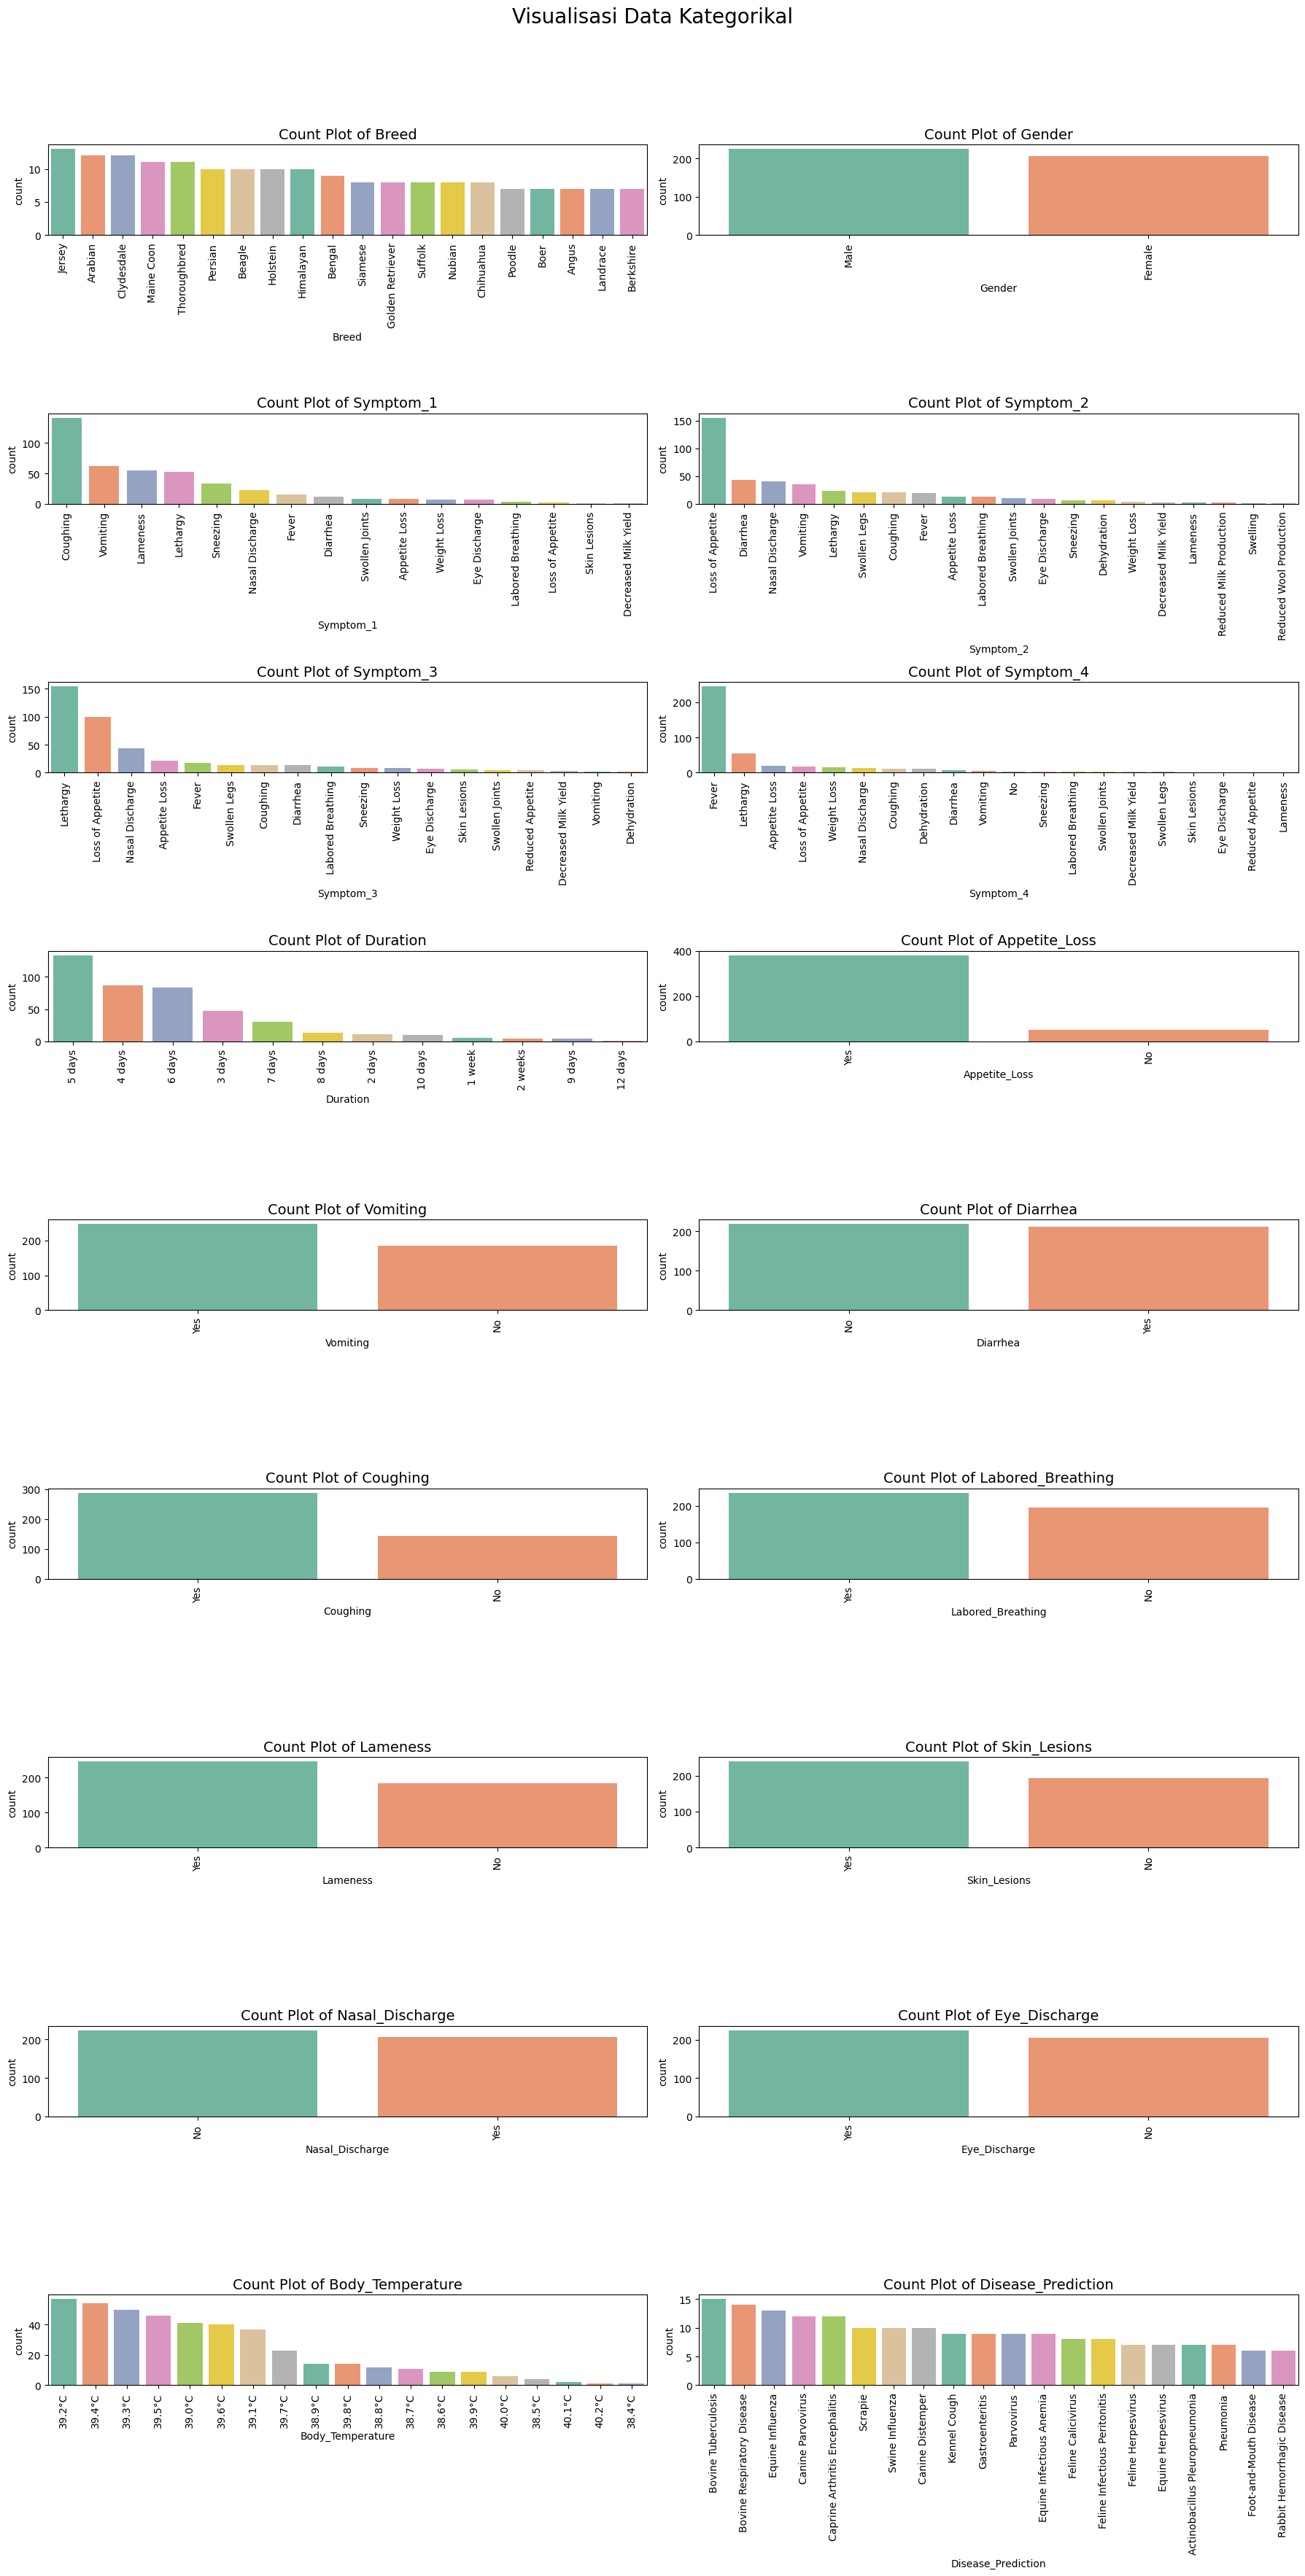

In [9]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
ncols, nrows = 2, (len(categorical_cols) + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows * 4))
fig.suptitle("Visualisasi Data Kategorikal", fontsize=20)
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    top_categories = df[col].value_counts().nlargest(20).index
    sns.countplot(data=df[df[col].isin(top_categories)], x=col, order=top_categories, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Count Plot of {col}', fontsize=14)
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

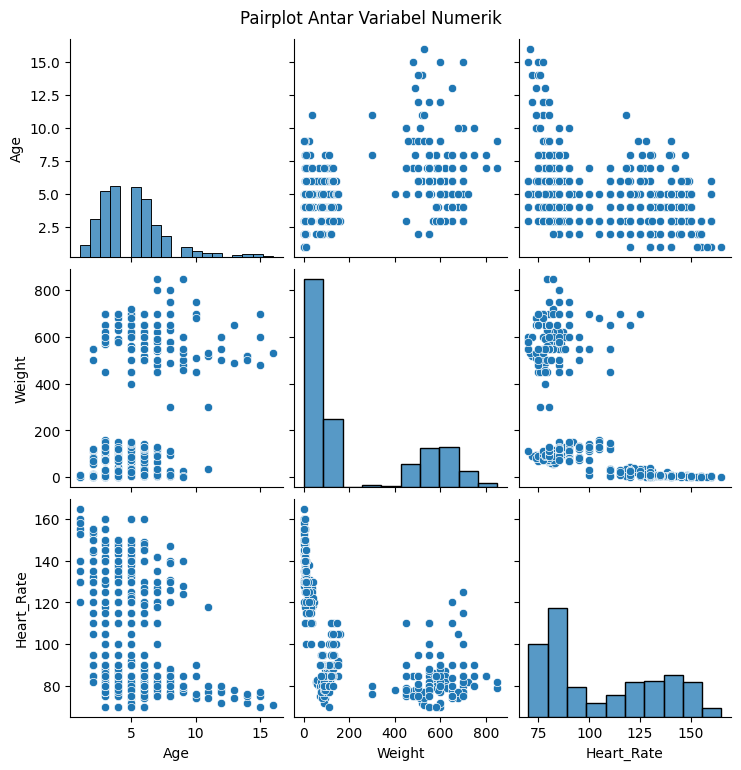

In [10]:
# Pairplot untuk hubungan antar variabel numerikal
sns.pairplot(df.select_dtypes(include=[np.number]))
plt.suptitle("Pairplot Antar Variabel Numerik", y=1.02)
plt.show()

## **4. Data Preparation**

In [11]:
binary_mapping = {'No': 0, 'Yes': 1, 'Male': 0, 'Female': 1}
for col in ['Gender', 'Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing',
            'Labored_Breathing', 'Lameness', 'Skin_Lesions',
            'Nasal_Discharge', 'Eye_Discharge']:
    df[col] = df[col].replace(binary_mapping).infer_objects(copy=False)

In [12]:
# Label Encoding
label_encoders = {}
categorical_cols = ['Breed', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4',
                    'Duration', 'Body_Temperature', 'Disease_Prediction']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [13]:
df.head()

,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Duration,Appetite_Loss,...,Diarrhea,Coughing,Labored_Breathing,Lameness,Skin_Lesions,Nasal_Discharge,Eye_Discharge,Body_Temperature,Heart_Rate,Disease_Prediction
0,63,4,0,25.0,5,9,0,21,5,1,...,0,0,0,0,0,0,0,11,120,109
1,101,2,1,4.5,1,14,5,11,0,0,...,0,1,0,0,0,1,1,5,150,136
2,57,3,1,600.0,5,11,7,1,7,1,...,0,1,1,0,0,1,0,17,90,86
3,12,1,0,10.0,3,18,8,0,3,1,...,1,0,0,0,0,0,0,8,130,90
4,81,5,0,3.8,8,0,12,12,4,1,...,0,0,0,0,1,0,0,3,160,89


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Breed               431 non-null    int64  
 1   Age                 431 non-null    int64  
 2   Gender              431 non-null    int64  
 3   Weight              431 non-null    float64
 4   Symptom_1           431 non-null    int64  
 5   Symptom_2           431 non-null    int64  
 6   Symptom_3           431 non-null    int64  
 7   Symptom_4           431 non-null    int64  
 8   Duration            431 non-null    int64  
 9   Appetite_Loss       431 non-null    int64  
 10  Vomiting            431 non-null    int64  
 11  Diarrhea            431 non-null    int64  
 12  Coughing            431 non-null    int64  
 13  Labored_Breathing   431 non-null    int64  
 14  Lameness            431 non-null    int64  
 15  Skin_Lesions        431 non-null    int64  
 16  Nasal_Di

In [15]:
label_counts = df['Disease_Prediction'].value_counts()
valid_labels = label_counts[label_counts >= 9].index
filtered_df = df[df['Disease_Prediction'].isin(valid_labels)]

# Split data
X = filtered_df.drop(columns=['Disease_Prediction'])
y = filtered_df['Disease_Prediction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## **5. Modelling & Evaluation**

### 5.1 Latih Model dengan Random Forest

In [16]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)

In [17]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("Random Forest Evaluation")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2%}, F1: {f1_score(y_train, y_train_pred, average='weighted'):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2%}, F1: {f1_score(y_test, y_test_pred, average='weighted'):.2f}")

Random Forest Evaluation
Train Accuracy: 100.00%, F1: 1.00
Test Accuracy: 70.37%, F1: 0.69


### 5.2 Latih Model dengan XG Boost

In [18]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(le.classes_),
                          eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
print("XGBoost Evaluation")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2%}, F1: {f1_score(y_train, y_train_pred, average='weighted'):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2%}, F1: {f1_score(y_test, y_test_pred, average='weighted'):.2f}")

XGBoost Evaluation
Train Accuracy: 100.00%, F1: 1.00
Test Accuracy: 70.37%, F1: 0.69


## **6. Tunning**

In [19]:
# Hyperparameter Tuning - Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params,
                               n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)
print("Best Random Forest Params:", rf_search.best_params_)
print("Best Score:", rf_search.best_score_)

Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Best Score: 0.5238095238095238


In [20]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
                                xgb_params, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
xgb_search.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_search.best_params_)
print("Best Score:", xgb_search.best_score_)

Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Best Score: 0.4761904761904762


In [21]:
best_model = rf_search.best_estimator_  # atau xgb_search.best_estimator_, dst.
best_model.predict(X_test)

array([ 4,  0, 10,  9,  5,  1,  6,  6,  3,  9,  4,  6, 11,  1,  8,  2,  0,
        3,  3, 10,  3, 10,  7,  1,  8,  1,  6])

In [22]:
best_model = xgb_search.best_estimator_
best_model.predict(X_test)

array([ 4,  1, 10,  9,  6,  0,  6,  6,  3,  9,  4,  6, 11,  1,  8,  2,  5,
        3,  3,  4,  3, 10,  7,  1,  8,  0,  6])

## **Konversi Model**

Menyimpan dan Memuat Model (Deployment ke Backend)

In [23]:
# Simpan model
joblib.dump(rf_model, "best_model.pkl")
# Menyimpan label encoder
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

# **Testing**

In [24]:
# Load model
model = joblib.load("best_model.pkl")

# Jika ada scaler, load juga
try:
    scaler = joblib.load("scaler.pkl")
except:
    scaler = None

# Jika ada label encoder, load
try:
    label_encoders = joblib.load("label_encoders.pkl")
except:
    label_encoders = None

# Ambil satu sample dari data uji
input_df = X_test.iloc[[0]]
print("Data input:\n", input_df)

# Simpan label aslinya (jika ingin dibandingkan)
true_label = y_test[0]

# Scaling jika diperlukan
if scaler:
    input_scaled = scaler.transform(input_df)
else:
    input_scaled = input_df

# Prediksi kelas
prediksi = model.predict(input_scaled)[0]

# Probabilitas prediksi
if hasattr(model, "predict_proba"):
    proba = model.predict_proba(input_scaled)
    class_index = list(model.classes_).index(prediksi)
    confidence = proba[0][class_index] * 100
else:
    confidence = "N/A"

# Decode label jika perlu
if label_encoders and 'Disease_Prediction' in label_encoders:
    prediksi_label = label_encoders['Disease_Prediction'].inverse_transform([prediksi])[0]
    true_label = label_encoders['Disease_Prediction'].inverse_transform([true_label])[0]
else:
    prediksi_label = prediksi

# Tampilkan hasil
print(f"Hasil Prediksi: {prediksi_label}")
print(f"Akurasi Prediksi (confidence): {confidence:.2f}%")
print(f"Label Sebenarnya: {true_label}")

Data input:
      Breed  Age  Gender  Weight  Symptom_1  Symptom_2  Symptom_3  Symptom_4  \
375      3    3       1    75.0         14          4          8          6   

     Duration  Appetite_Loss  Vomiting  Diarrhea  Coughing  Labored_Breathing  \
375         6              1         1         1         1                  1   

     Lameness  Skin_Lesions  Nasal_Discharge  Eye_Discharge  Body_Temperature  \
375         1             1                1              1                13   

     Heart_Rate  
375          95  
Hasil Prediksi: Caprine Arthritis Encephalitis
Akurasi Prediksi (confidence): 62.00%
Label Sebenarnya: Arthritis


Mengkonversi untuk Web Deployment (Flask, FastAPI)

In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)
model = joblib.load('best_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    input_data = request.json
    input_df = pd.DataFrame([input_data])
    prediction = model.predict(input_df)[0]
    return jsonify({'prediction': int(prediction)})

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
